# ID Card Detection


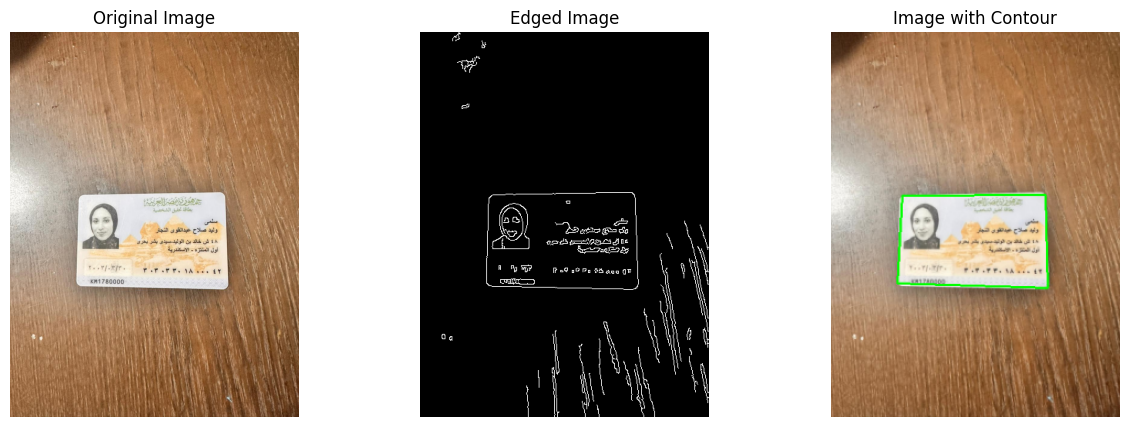

In [91]:
# Import required libraries
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt

# Path to the uploaded image
image_path = 'test.jpeg'

def detect_ID(image):
    """
    Detects the ID card in the image.
    Returns the edged and image_contour.
    """
    image = imutils.resize(image, height = 500)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edged = cv2.Canny(blurred, 50, 150)

    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            break
        else:
            print("Cannot find 4 edges")

    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    image_contour=imutils.resize(image, height = 350)


    return edged, image_contour, cnts

image = cv2.imread(image_path)

edged,image_contour,contours = detect_ID(image)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the edged image
axes[1].imshow(edged, cmap='gray')
axes[1].set_title('Edged Image')
axes[1].axis('off')

# Display the image with contour
axes[2].imshow(cv2.cvtColor(image_contour, cv2.COLOR_BGR2RGB))
axes[2].set_title('Image with Contour')
axes[2].axis('off')

# Show the plot
plt.show()


#  Correct Alignment

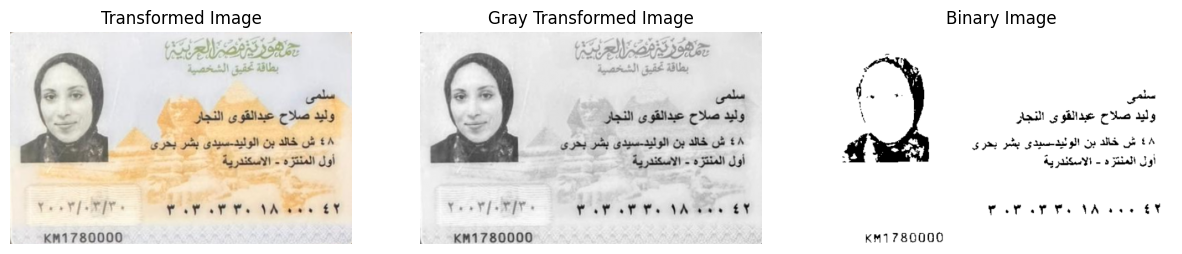

In [102]:
def correct_alignment(image, contours):

    # Find the largest rectangular contour
    max_contour = max(contours, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, epsilon, True)
    ratio = image.shape[0] / 500.0
    orig = image.copy()
    if len(approx) == 4:  # If we detect a rectangle (ID card)
        pts = approx.reshape(4, 2) * ratio
        # Warp perspective to get a top-down view
        # Order points: top-left, top-right, bottom-right, bottom-left
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # Dimensions of the output image
        rect = order_points(pts)
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

        image_Trasform=imutils.resize(warped, height = 350)
        warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
        image_Tgraym=imutils.resize(warped, height = 350)
        val, dst = cv2.threshold(warped,120,255,cv2.THRESH_BINARY)
        orig=imutils.resize(orig, height = 350)
        dst=imutils.resize(dst, height = 350)
        return image_Trasform, image_Tgraym, dst

image_Trasform, image_Tgraym, dst = correct_alignment(image, contours)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display image_Trasform
axes[0].imshow(cv2.cvtColor(image_Trasform, cv2.COLOR_BGR2RGB))
axes[0].set_title('Transformed Image')
axes[0].axis('off')

# Display image_Tgraym
axes[1].imshow(image_Tgraym, cmap='gray')
axes[1].set_title('Gray Transformed Image')
axes[1].axis('off')

# Display dst
axes[2].imshow(dst, cmap='gray')
axes[2].set_title('Binary Image')
axes[2].axis('off')

# Show the plot
plt.show()

# Line Segmentation

In [24]:
!sudo apt-get install tesseract-ocr
!sudo apt-get install tesseract-ocr-ara
! apt install libtesseract-dev
! pip install Pillow
! pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-ara is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 3,743 kB of archives.
After this operation, 16.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libarchive-dev amd64 3.6.0-

In [47]:
! sudo mv "/content/ara.traineddata" "/usr/share/tesseract-ocr/4.00/tessdata"
! sudo mv "/content/ara_combined.traineddata" "/usr/share/tesseract-ocr/4.00/tessdata"
! sudo mv "/content/ara_number.traineddata" "/usr/share/tesseract-ocr/4.00/tessdata"


mv: cannot stat '/content/ara.traineddata': No such file or directory
mv: cannot stat '/content/ara_combined.traineddata': No such file or directory
mv: cannot stat '/content/ara_number.traineddata': No such file or directory


In [103]:
def extract_Text(warped):
    height,width = warped.shape[:2]
    h = int(height/4) + 5
    w=int(width/4)
    image1=warped.copy()
    strs = ["" for x in range(4)]
    for i in range(1,4):
        if (i==1):
            image = image1[h*i-10:h*(i+1)-15,w:w*4]
            img_name=image.copy()
            text = pytesseract.image_to_string(image,lang='ara')
            strs[i-1] = text

        elif (i==2):
            image = image1[h*i-20:h*(i+1)-25,w-2:w*4]
            img_add=image.copy()
            text = pytesseract.image_to_string(image,lang='ara_combined')
            strs[i-1] = text

        elif (i==3):
            image = image1[h*i-15:h*(i+1)-45,int(w*0.43):w*4]
            img_ID= image.copy()
            text = pytesseract.image_to_string(image,lang='ara_number')
            strs[i-1] = text
    print("Name : " + strs[0])
    print("Address : " + strs[1])
    print("NID : " + strs[2])
    return img_name,img_add,img_ID

Name : اسلمى
وليد صلاح عبدالقوى النجار

Address : ۸ ش خالد بن الولید-سیدی ہشر بحری
أول المنتزه - الاسكندرية

 

NID : 25303301800042



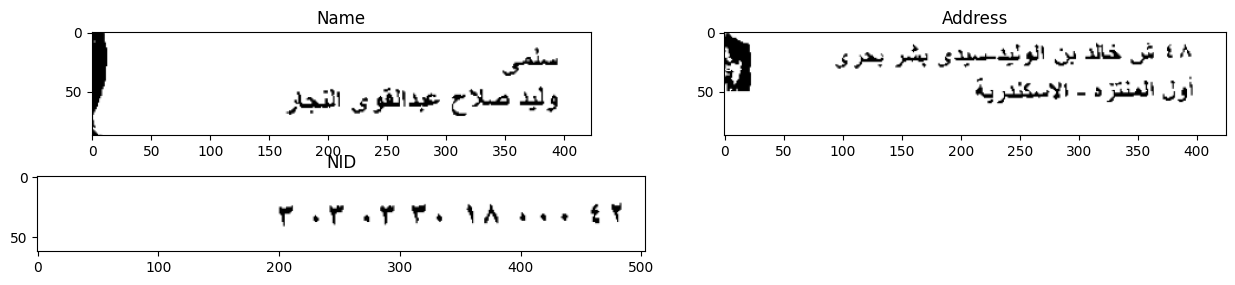

In [104]:
img_name,img_add,img_ID=extract_Text(dst)
img_dict={"Name":img_name,"Address":img_add,"NID":img_ID}
view_imgs(img_dict, 2, type ='BGR')